# Layout Engines: Choosing the Right Spatial Discretization

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand the different layout engines available in neurospatial
- Choose the appropriate layout for your experimental setup
- Create environments with regular grids, hexagonal tessellations, and polygon boundaries
- Compare connectivity patterns across different layouts
- Understand the trade-offs between different discretization strategies

**Estimated time: 20-25 minutes**

## What Are Layout Engines?

A **layout engine** defines how continuous space is discretized into bins. Different experimental setups benefit from different discretization strategies:

- **RegularGridLayout**: Standard rectangular grids (most common)
- **HexagonalLayout**: Hexagonal tessellations (uniform neighbor distances)
- **ShapelyPolygonLayout**: Grid bounded by arbitrary polygons (circular arenas, complex shapes)
- **MaskedGridLayout**: Grids with explicit active/inactive regions
- **ImageMaskLayout**: Binary image-based layouts
- **TriangularMeshLayout**: Triangular tessellations
- **GraphLayout**: 1D linearized tracks (covered in notebook 05)

You typically don't interact with layout engines directly—factory methods like `from_samples()` handle them for you!

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon

from neurospatial import Environment

np.random.seed(42)
plt.rcParams["figure.figsize"] = (12, 10)

## 1. Regular Grid Layout (Default)

This is the standard rectangular grid you've already seen in notebook 01. It's the default layout for `from_samples()`.

In [2]:
# Generate sample data for a square arena
n_samples = 2000
square_data = np.random.uniform(0, 50, size=(n_samples, 2))

# Create regular grid environment
env_regular = Environment.from_samples(
    positions=square_data, bin_size=5.0, name="RegularGrid"
)

print("Regular Grid Environment:")
print(f"  Layout type: {env_regular.layout._layout_type_tag}")
print(f"  Number of bins: {env_regular.n_bins}")
print(f"  Grid shape: {env_regular.grid_shape}")

Regular Grid Environment:
  Layout type: RegularGrid
  Number of bins: 121
  Grid shape: (11, 11)


### Connectivity: Orthogonal vs Diagonal

Regular grids support two connectivity patterns:

In [3]:
# Orthogonal neighbors only (4-connectivity in 2D)
env_orthogonal = Environment.from_samples(
    positions=square_data,
    bin_size=5.0,
    connect_diagonal_neighbors=False,
    name="Orthogonal",
)

# Include diagonal neighbors (8-connectivity in 2D)
env_diagonal = Environment.from_samples(
    positions=square_data,
    bin_size=5.0,
    connect_diagonal_neighbors=True,
    name="Diagonal",
)

# Compare number of edges
print(f"Orthogonal connectivity: {env_orthogonal.connectivity.number_of_edges()} edges")
print(f"Diagonal connectivity: {env_diagonal.connectivity.number_of_edges()} edges")

Orthogonal connectivity: 220 edges
Diagonal connectivity: 420 edges


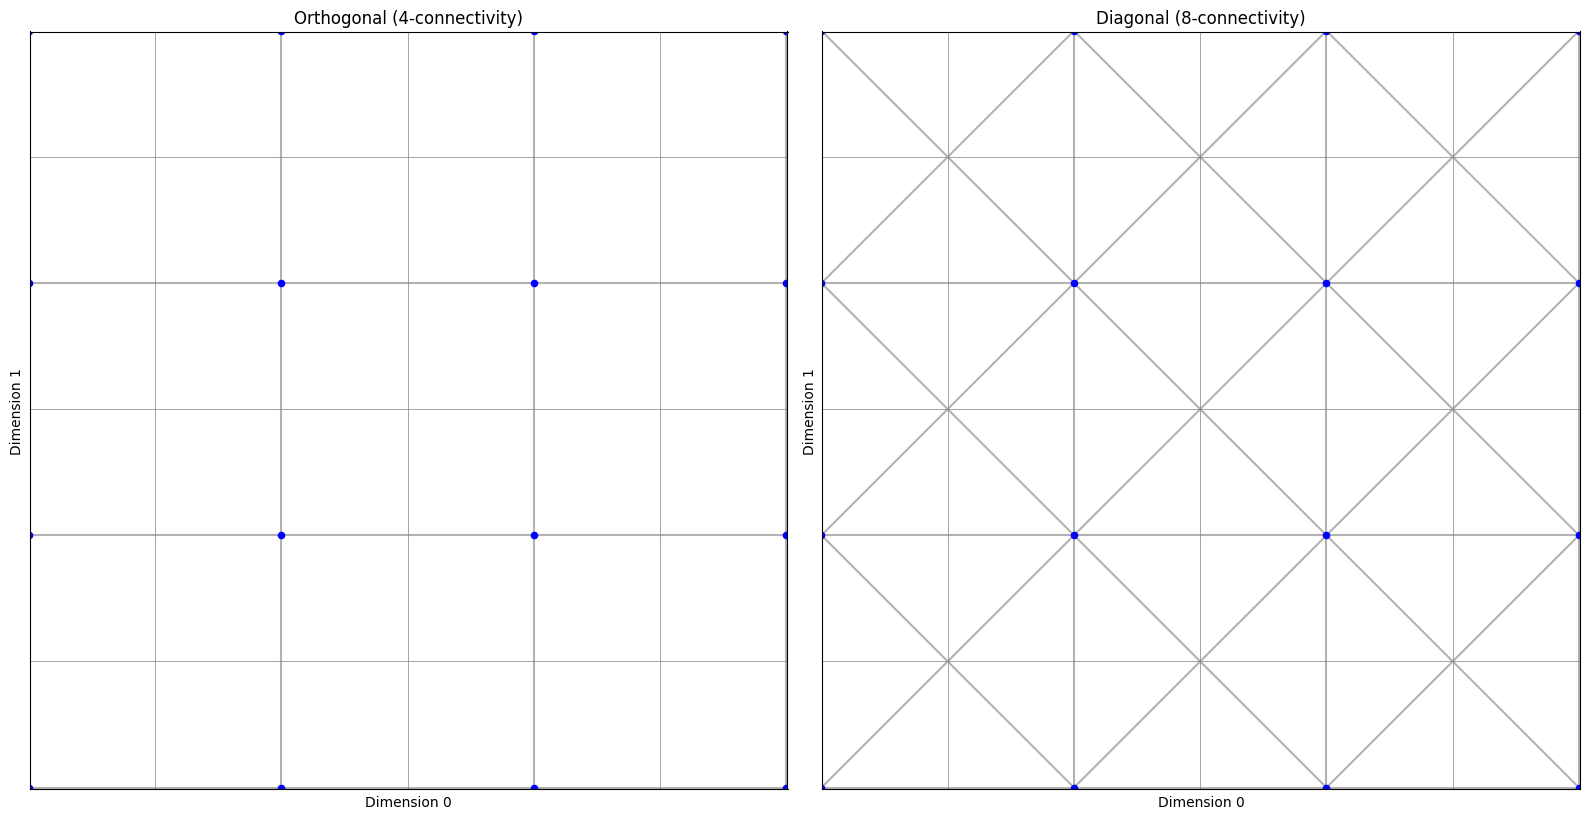

In [4]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Zoom in on a small region to see connectivity
for ax, env, title in zip(
    axes,
    [env_orthogonal, env_diagonal],
    ["Orthogonal (4-connectivity)", "Diagonal (8-connectivity)"],
    strict=False,
):
    env.plot(ax=ax, show_connectivity=True)
    ax.set_xlim(20, 35)
    ax.set_ylim(20, 35)
    ax.set_title(title)

plt.tight_layout()
plt.show()

**When to use each:**
- **Orthogonal**: Simpler, matches cardinal directions, faster computation
- **Diagonal**: More realistic for free movement, shorter path distances

## 2. Hexagonal Layout

Hexagonal tessellations have a key advantage: **all neighbors are equidistant** from the center bin. This creates more uniform spatial sampling.

In [5]:
# Create hexagonal environment
env_hex = Environment.from_samples(
    positions=square_data,
    layout="Hexagonal",  # Specify layout type
    bin_size=5.0,  # This is the hexagon width (flat-to-flat distance)
    name="Hexagonal",
)

print("Hexagonal Environment:")
print(f"  Layout type: {env_hex.layout._layout_type_tag}")
print(f"  Number of bins: {env_hex.n_bins}")
print(f"  Number of edges: {env_hex.connectivity.number_of_edges()}")

Hexagonal Environment:
  Layout type: Hexagonal
  Number of bins: 134
  Number of edges: 355


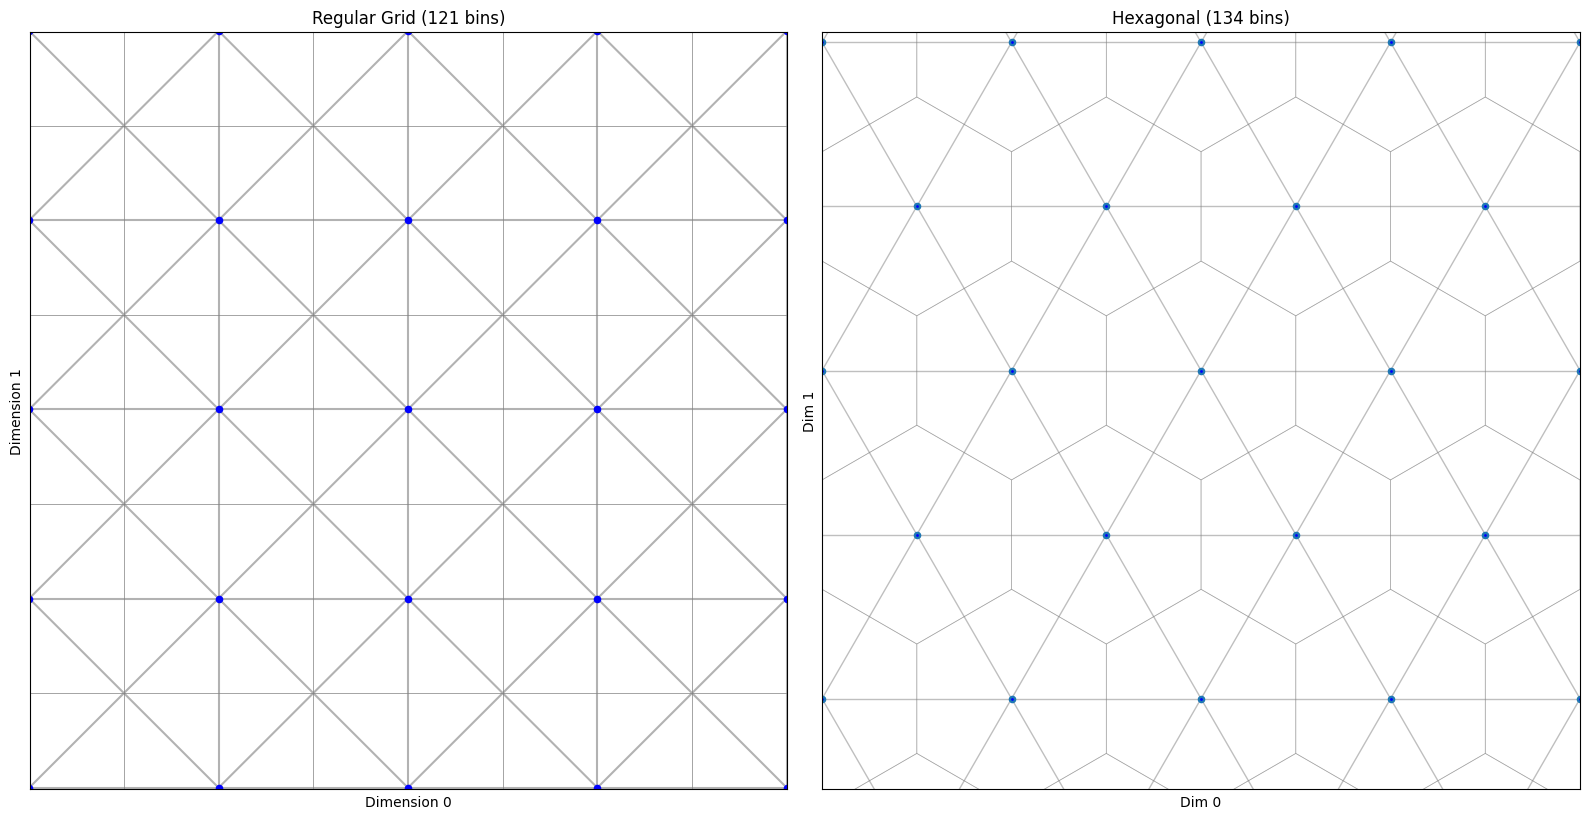

In [6]:
# Compare regular grid vs hexagonal
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

env_regular.plot(ax=axes[0], show_connectivity=True)
axes[0].set_title(f"Regular Grid ({env_regular.n_bins} bins)")
axes[0].set_xlim(15, 35)
axes[0].set_ylim(15, 35)

env_hex.plot(ax=axes[1], show_connectivity=True)
axes[1].set_title(f"Hexagonal ({env_hex.n_bins} bins)")
axes[1].set_xlim(15, 35)
axes[1].set_ylim(15, 35)

plt.tight_layout()
plt.show()

### Neighbor Distance Analysis

Let's verify that hexagonal layouts have more uniform neighbor distances:

In [7]:
def analyze_neighbor_distances(env, name):
    """Compute statistics about neighbor distances."""
    distances = []
    for _, _, data in env.connectivity.edges(data=True):
        distances.append(data["distance"])

    distances = np.array(distances)
    print(f"\n{name}:")
    print(f"  Mean distance: {distances.mean():.3f} cm")
    print(f"  Std distance: {distances.std():.3f} cm")
    print(f"  Min distance: {distances.min():.3f} cm")
    print(f"  Max distance: {distances.max():.3f} cm")
    print(f"  Coefficient of variation: {distances.std() / distances.mean():.3f}")
    return distances


regular_distances = analyze_neighbor_distances(env_diagonal, "Regular Grid (diagonal)")
hex_distances = analyze_neighbor_distances(env_hex, "Hexagonal")


Regular Grid (diagonal):
  Mean distance: 5.980 cm
  Std distance: 1.033 cm
  Min distance: 4.992 cm
  Max distance: 7.064 cm
  Coefficient of variation: 0.173

Hexagonal:
  Mean distance: 5.000 cm
  Std distance: 0.000 cm
  Min distance: 5.000 cm
  Max distance: 5.000 cm
  Coefficient of variation: 0.000


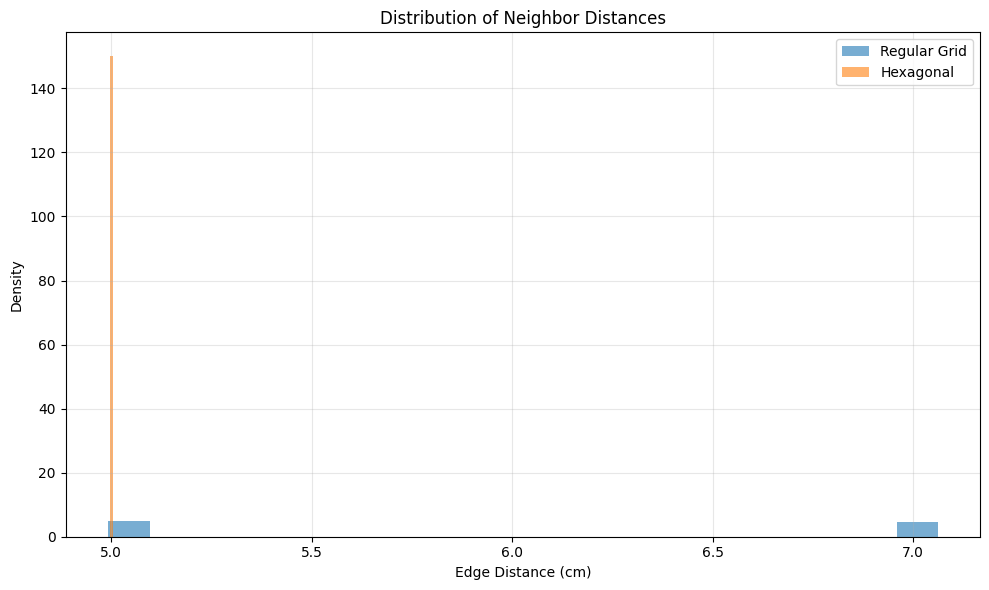

In [8]:
# Plot distance distributions
fig, ax = plt.subplots(figsize=(10, 6))


# Use explicit bins to handle uniform hexagonal data
# For uniform data (single value), use fewer bins; for varied data, use 20
def get_bins_and_range(distances):
    """Determine appropriate bins and range for histogram."""
    min_val = distances.min()
    max_val = distances.max()

    # If all values are the same, create a narrow range around that value
    if np.isclose(min_val, max_val):
        range_val = (min_val - 0.01, max_val + 0.01)
        return 3, range_val  # Use just 3 bins for uniform data
    else:
        # For varied data, use 20 bins
        range_val = (min_val, max_val)
        return 20, range_val


regular_bins, regular_range = get_bins_and_range(regular_distances)
hex_bins, hex_range = get_bins_and_range(hex_distances)

ax.hist(
    regular_distances,
    bins=regular_bins,
    alpha=0.6,
    label="Regular Grid",
    density=True,
    range=regular_range,
)
ax.hist(
    hex_distances,
    bins=hex_bins,
    alpha=0.6,
    label="Hexagonal",
    density=True,
    range=hex_range,
)

ax.set_xlabel("Edge Distance (cm)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Neighbor Distances")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Key insight:** Hexagonal layouts have a single peak (uniform distances), while regular grids have two peaks (orthogonal vs diagonal distances).

## 3. Polygon-Bounded Layouts

Real experiments often use circular arenas, water mazes, or other non-rectangular environments. Polygon-bounded layouts let you specify an exact boundary.

### Example 1: Circular Arena

A common experimental setup in rodent neuroscience:

In [9]:
# Define a circular arena (50 cm diameter)
center = Point(50, 50)
radius = 25.0
circle = center.buffer(radius)

# Create environment bounded by circle
env_circle = Environment.from_polygon(
    polygon=circle, bin_size=3.0, name="CircularArena"
)

print("Circular Arena:")
print(f"  Radius: {radius} cm")
print(f"  Active bins: {env_circle.n_bins}")
print(f"  Grid shape: {env_circle.grid_shape}")

Circular Arena:
  Radius: 25.0 cm
  Active bins: 225
  Grid shape: (17, 17)


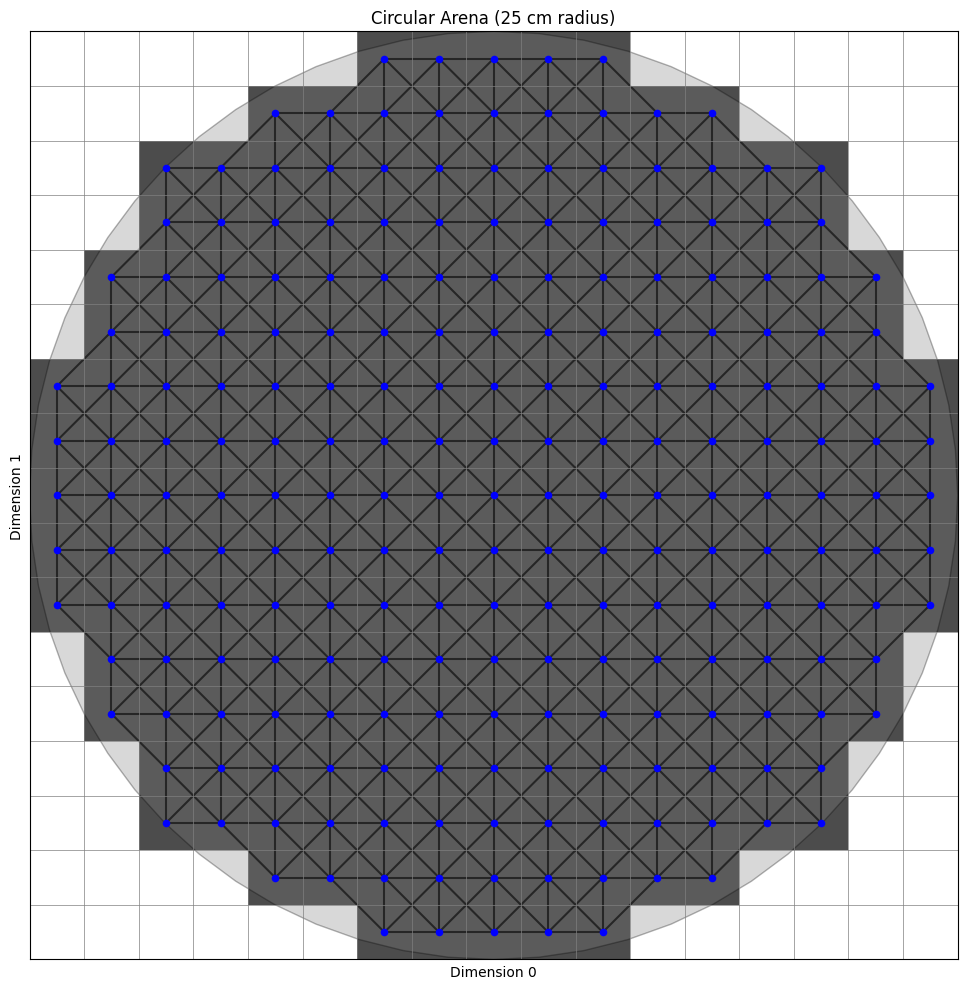

In [10]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 10))
env_circle.plot(ax=ax, show_connectivity=True)
ax.set_title("Circular Arena (25 cm radius)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Example 2: Complex Polygon Shape

You can define arbitrary polygons for complex environments:

In [11]:
# Define a T-maze shape
t_maze_coords = [
    # Horizontal bar (top of T)
    (0, 40),
    (60, 40),
    (60, 50),
    (0, 50),
    (0, 40),  # Close at junction
    # Vertical bar (stem of T)
    (25, 40),
    (25, 0),
    (35, 0),
    (35, 40),
    # Close back at junction
    (25, 40),
]

# Create proper polygon
t_maze_polygon = Polygon(
    [
        (0, 40),
        (0, 50),
        (25, 50),
        (25, 60),
        (35, 60),
        (35, 50),
        (60, 50),
        (60, 40),
        (35, 40),
        (35, 0),
        (25, 0),
        (25, 40),
    ]
)

env_tmaze = Environment.from_polygon(polygon=t_maze_polygon, bin_size=3.0, name="TMaze")

print("T-Maze Environment:")
print(f"  Active bins: {env_tmaze.n_bins}")

T-Maze Environment:
  Active bins: 144


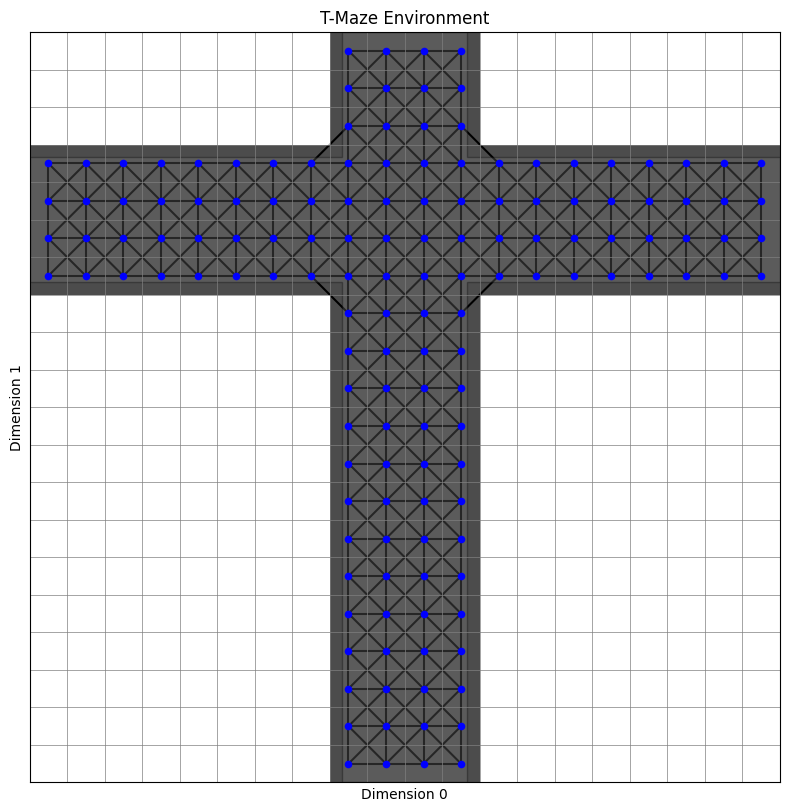

In [12]:
fig, ax = plt.subplots(figsize=(8, 10))
env_tmaze.plot(ax=ax, show_connectivity=True)
ax.set_title("T-Maze Environment")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## 4. Comparing All Layouts Side-by-Side

Let's create the same circular arena with different layout types:

In [13]:
# Generate data inside a circle
n_samples = 2000
angles = np.random.uniform(0, 2 * np.pi, n_samples)
radii = (
    np.sqrt(np.random.uniform(0, 1, n_samples)) * 23
)  # sqrt for uniform distribution
circle_data = np.column_stack(
    [50 + radii * np.cos(angles), 50 + radii * np.sin(angles)]
)

# Create with different layouts
circle_polygon = Point(50, 50).buffer(25)

envs_comparison = {
    "Regular Grid\n(from_samples)": Environment.from_samples(
        positions=circle_data, bin_size=4.0, name="Regular"
    ),
    "Regular Grid\n(from_polygon)": Environment.from_polygon(
        polygon=circle_polygon, bin_size=4.0, name="RegularPoly"
    ),
    "Hexagonal\n(from_samples)": Environment.from_samples(
        positions=circle_data,
        layout="Hexagonal",
        bin_size=4.0,
        name="HexSamples",
    ),
}

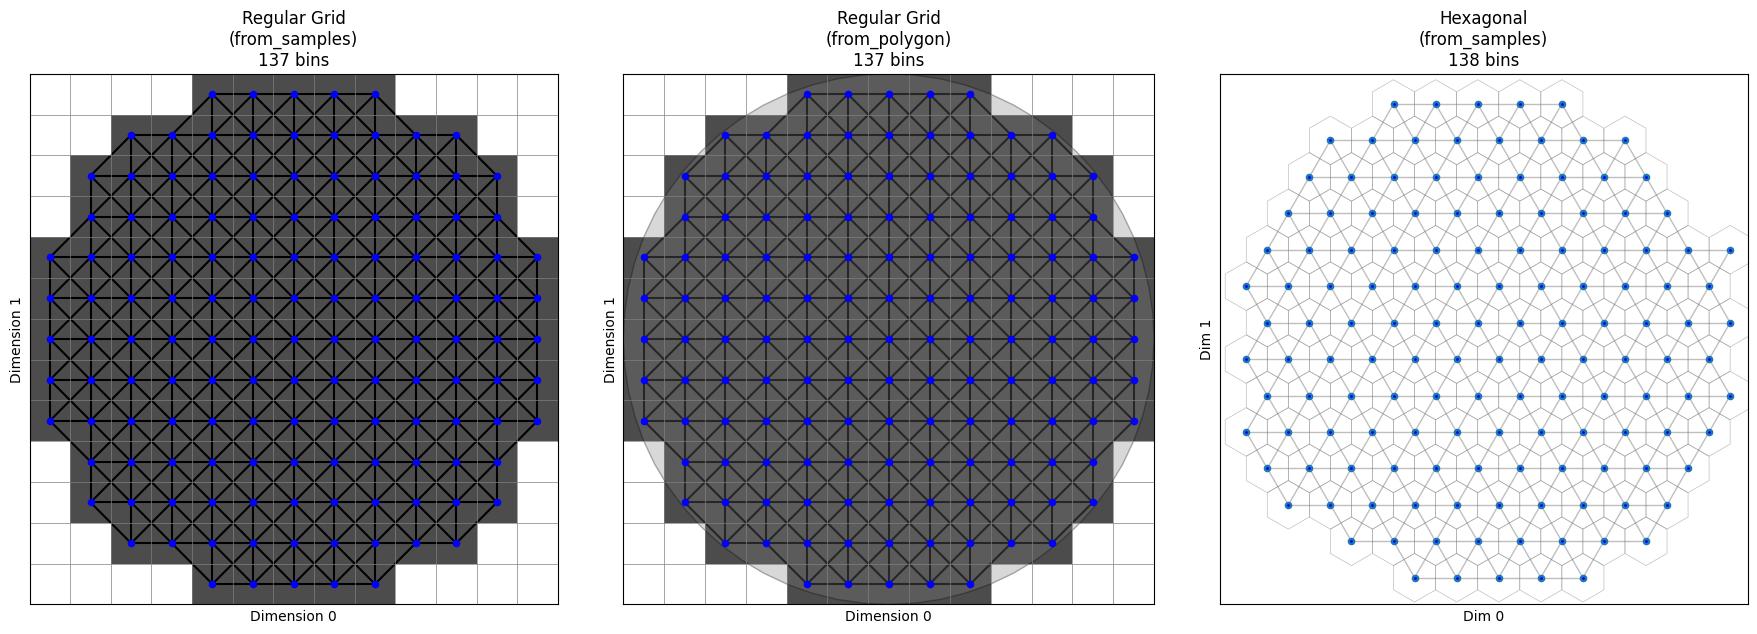

In [14]:
# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (title, env) in zip(axes, envs_comparison.items(), strict=False):
    env.plot(ax=ax, show_connectivity=True)
    ax.set_title(f"{title}\n{env.n_bins} bins")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

## 5. When to Use Each Layout

Here's a decision guide:

| Layout | Best For | Advantages | Disadvantages |
|--------|----------|------------|---------------|
| **Regular Grid** | Most applications, rectangular arenas | Simple, intuitive, fast | Non-uniform neighbor distances (with diagonal) |
| **Hexagonal** | Isotropic analysis, grid cells | Uniform neighbor distances, natural for some patterns | Slightly more complex, can't tile rectangles perfectly |
| **Polygon-bounded** | Circular arenas, water mazes, custom shapes | Exact boundaries, matches physical setup | Requires polygon definition |
| **Graph** (next notebook) | Linear tracks, mazes, 1D analysis | True 1D representation, handles complex track geometry | Only for track-like environments |

**Default recommendation:** Start with regular grid (`from_samples()`). It works for 95% of use cases!

## 6. Layout Parameters Summary

Key parameters that affect layout creation:

In [15]:
# Regular grid parameters
env1 = Environment.from_samples(
    positions=square_data,
    bin_size=5.0,  # Size of bins
    connect_diagonal_neighbors=True,  # Include diagonal connections
    infer_active_bins=True,  # Auto-detect active bins
    bin_count_threshold=1,  # Min samples per active bin
    name="FullyConfigured",
)

# Hexagonal parameters
env2 = Environment.from_samples(
    positions=square_data,
    layout="Hexagonal",
    bin_size=5.0,  # Hexagon width (flat-to-flat)
    infer_active_bins=True,
    name="HexConfigured",
)

# Polygon parameters (from_polygon always uses RegularGrid layout)
env3 = Environment.from_polygon(
    polygon=circle_polygon,
    bin_size=5.0,
    connect_diagonal_neighbors=True,
    name="PolyConfigured",
)

print("All environments created successfully!")

All environments created successfully!


## Key Takeaways

1. **Layout engines** define how space is discretized into bins
2. **Regular grids** are the default and work for most applications
3. **Hexagonal layouts** provide uniform neighbor distances
4. **Polygon-bounded layouts** match physical arena boundaries (circles, custom shapes)
5. **Connectivity patterns** (orthogonal vs diagonal) affect path distances and computation
6. Choose layouts based on:
   - Physical arena shape
   - Analysis requirements (isotropy, path distances)
   - Computational considerations

## Next Steps

In the next notebook (**03_morphological_operations.ipynb**), you'll learn:
- How to handle sparse or patchy data
- Morphological operations: dilate, fill_holes, close_gaps
- Controlling active bin inference
- Dealing with noisy position tracking

## Exercises (Optional)

1. Create a hexagonal environment for a circular arena and compare bin count with regular grid
2. Design a custom polygon for a figure-8 maze
3. Compare shortest path distances between two points using orthogonal vs diagonal connectivity
4. Calculate the average number of neighbors per bin for each layout type